# Neural Networks for Eddy Covarinace

In [105]:
## Import some standard packages and define a few functions
import time
import importlib
import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn import metrics
import matplotlib.pyplot as plt
from Scripts import PlotHelpers
from matplotlib.colors import Normalize
from Scripts import ReadDB, MiscFuncs, NNetFuncs, RF_Mod

dbNames = {
    'Clean/SecondStage/TA_1_1_1':'TA',
    'Clean/SecondStage/RH_1_1_1':'RH',
    'Clean/SecondStage/FC':'FCO2',
    'Clean/SecondStage/FCH4':'FCH4',
    'Clean/SecondStage/PPFD_IN_1_1_1':'PPFD',
    'Clean/SecondStage/P_1_1_1':'P',
    'Flux/qc_co2_flux':'qc_FCO2',
    'Flux/qc_ch4_flux':'qc_FCH4',
    'Clean/SecondStage/USTAR':'USTAR',
    'Clean/SecondStage/TS_1':'TS_1',
    'Clean/SecondStage/TS_2':'TS_2',
    'Clean/SecondStage/TS_3':'TS_3',
    'Clean/SecondStage/wind_speed':'U',
    'Clean/SecondStage/wind_dir':'dir',
    'Met/MET_WaterLevel_Avg':'WTD_raw',
    'Clean/SecondStage/WTD_1_1_1':'WTD',
}

Local = '/mnt/c/Users/User/PostDoc_Work/database/'
Remote = '/mnt/w/'

Dir = Remote

Site = 'BB'

read_new = True
if read_new == True:
    Data = ReadDB.get_Traces(Site,list(dbNames.keys()),Dir=Dir)
    Data = Data.rename(columns=dbNames)
    Data.to_csv(f'temp/{Site}_VPD.csv')

else:
    Data = pd.read_csv(f'temp/{Site}_VPD.csv',parse_dates=['TimeStamp'],index_col='TimeStamp')


## Pre-processing

In [106]:
importlib.reload(ReadDB)

Data['VPD'] = MiscFuncs.Calc_VPD(Data['TA'],Data['RH'])
Data['DOY'] = Data.index.dayofyear

inputs = ['PPFD','VPD','TS_1','Rand']
target = ['FCO2']

Data['Rand']=np.random.random(Data['FCO2'].values.shape)
Data['Rand100']=Data['Rand']*100

print(Data[['FCO2','FCH4']].describe())
filter = ReadDB.filterFlux(Data,target)
filter.QA_QC()
filter.rain('P',thresh=1)
filter.MAD(z=7)
filter.uStar('USTAR',u_thresh=0.05)

Data[['FCO2_Clean','FCH4_Clean']] = filter.df[['FCO2','FCH4']].copy()

Clean_Data = filter.df.copy()


               FCO2          FCH4
count  37260.000000  42498.000000
mean      -0.333153     52.984230
std        4.312031     69.966599
min      -49.348000   -199.917206
25%       -1.711623      9.618972
50%       -0.131327     34.761662
75%        0.749001     90.470169
max       49.777348    695.056885


# Make Scenarios

In [107]:
def Config_Defauls(run,name):
    run['config']['Name']=name
    run['config']['Nodes']=[64]
    run['config']['Activation']=['relu']
    run['config']['epochs']=250
    run['config']['batch_size']=32
    run['config']['Norm']=True
    run['config']['N_models']=10
    run['config']['RF_comp']=True

    run['Training'] = {}
    run['Evaluation'] = {}
    run['Full'] = {}
    return(run)

    

Model_Runs = {
    'Noisy_Data':{
        'config':{
            'Name':'Noisy_Data',
            'target':['FCO2'],
            'inputs':['PPFD','VPD','TS_1','TS_2','USTAR'],
            },
        },
    'Feature_Detection':{
        'config':{
            'Name':'Feature_Detection',
            'target':['FCO2_Clean'],
            'inputs':['PPFD','VPD','TS_1','TS_2','TS_3','U','dir','Rand'],
            },
        },
}

for key in Model_Runs.keys():
    Model_Runs[key] = Config_Defauls(Model_Runs[key],key)
    target = Model_Runs[key]['config']['target']
    inputs = Model_Runs[key]['config']['inputs']
    Training,Validation = MiscFuncs.makeMask(Data.loc[Data[target+inputs].dropna().index],
                                             target,dropOut=.2)
    print(Training.shape,Validation.shape)
    Model_Runs[key]['Training']['X'] = Training[inputs].values
    Model_Runs[key]['Training']['Y'] = Training[target].values.flatten()
    Model_Runs[key]['Evaluation']['X'] = Validation[inputs].values
    Model_Runs[key]['Evaluation']['Y'] = Validation[target].values.flatten()
    Model_Runs[key]['Full']['X'] = Data[inputs].values
    Model_Runs[key]['Full']['Y'] = Data[target].values.flatten()
    Model_Runs[key]['config']['mean'] = Data[inputs].mean().values
    Model_Runs[key]['config']['variance'] = Data[inputs].std().values**2


(29756, 22) (7439, 22)
(13945, 22) (3486, 22)


## Build and train model

In [108]:
importlib.reload(NNetFuncs)

run = 'Noisy_Data'

NNetFuncs.make_Dense_model(Model_Runs[run]['config'])
NNetFuncs.train_model(Model_Runs[run]['config'],Model_Runs[run]['Training'])

Model: "Noisy_Data"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 normalization (Normalizatio  (None, 5)                0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
Training Time:
 370.75  Seconds

Training RF Model
Training Time:
 13.91  Seconds


# Run and evaluate trained model


NN Validation metrics (ensemble mean): 
r2 =  0.1353 
RMSE =  3.79721
Run Time:
 0.46  Seconds

Running RF Model


RF Model 
Validation metrics: 
r2 =  0.14851 
RMSE =  14.19853
Run Time:
 0.47  Seconds


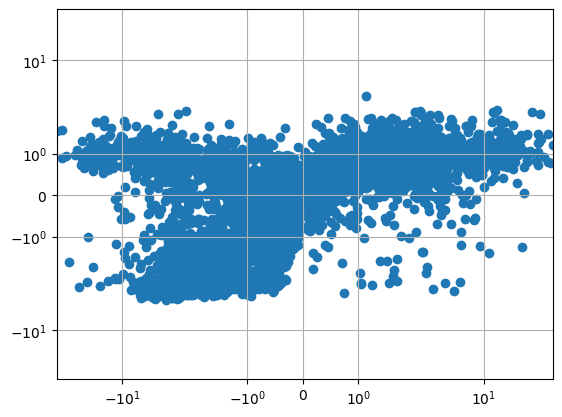

In [111]:
importlib.reload(NNetFuncs)


RI,Mean_Output,full_out=NNetFuncs.run_Model(Model_Runs[run]['config'],Model_Runs[run]['Evaluation'])

fig,ax=plt.subplots()
ax.scatter(Mean_Output['target'],Mean_Output['y_bar'])

Q_clip = 0

axLim = [Mean_Output[['target','y_bar']].quantile(Q_clip).min(),
         Mean_Output[['target','y_bar']].quantile(1-Q_clip).max()]
ax.set_ylim(axLim)
ax.set_xlim(axLim)
ax.set_yscale('symlog')
ax.set_xscale('symlog')
ax.grid()

## Relative influence of features

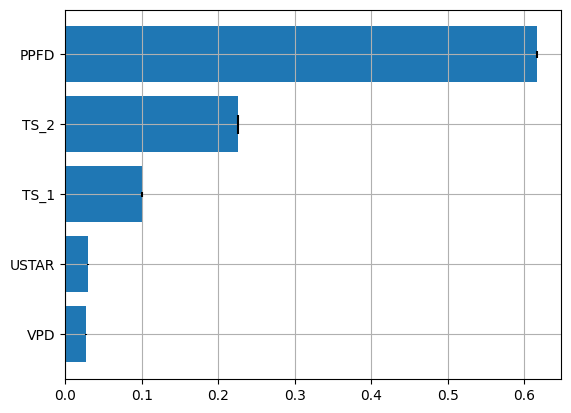

In [7]:
# Mean_Output['diff'] = (Mean_Output['target']-Mean_Output['y_bar']).abs()

mod = '_norm'

RI = RI.sort_values(by=f'RI{mod}_bar',ascending=True)
fig,ax=plt.subplots()

ax.barh(RI.index,RI[f'RI{mod}_bar'],yerr=RI[f'RI{mod}_CI95'])
ax.grid()


# Plot derivatives

KeyError: "None of [Index(['dy_dPPFDnorm'], dtype='object')] are in the [columns]"

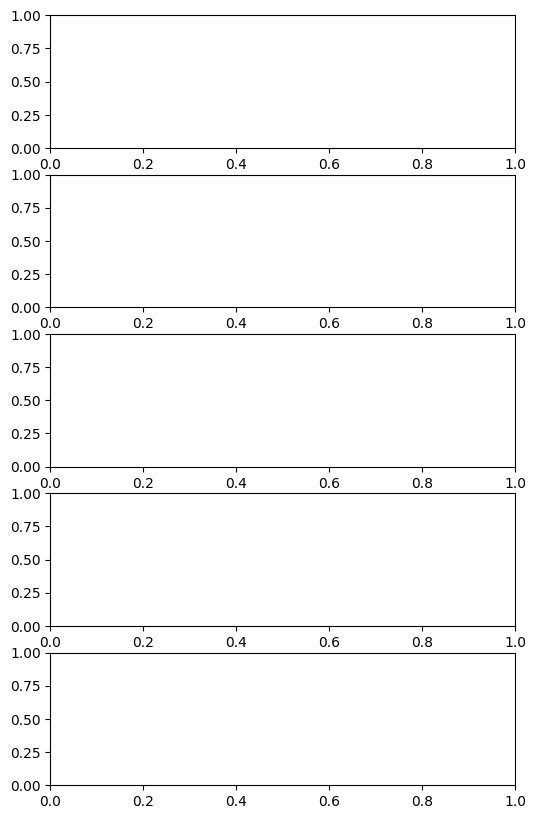

In [8]:
npi=len(RI.index)

fig,axes=plt.subplots(npi,sharey=True,figsize=(6,10))

mod = 'norm'

for i,xi in enumerate(Model_Runs[run]['config']['inputs']):
    df = MiscFuncs.byInterval(Mean_Output,f'{xi}',[f'dy_d{xi}{mod}'],bins=10)
    PlotHelpers.CI_Plot(axes[i],df,f'dy_d{xi}{mod}')
plt.tight_layout()

# Format the training data

KeyError: 'USTAR'

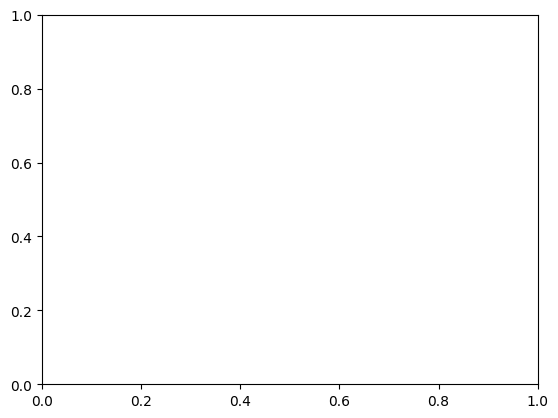

In [ ]:
fig,ax=plt.subplots()
# ax.scatter(Mean_Output['target'],Mean_Output['y_bar'])

# fig,axes=plt.subplots(npi,sharey=True,figsize=(6,10))

# for i,xi in enumerate(Model_Runs[run]['config']['inputs']):
xi='USTAR'
df = MiscFuncs.byInterval(Mean_Output.loc[Mean_Output['PPFD']<100].copy(),
                            f'{xi}',[f'dy_d{xi}{mod}'],bins=100)
PlotHelpers.CI_Plot(ax,df,f'dy_d{xi}{mod}')

In [31]:

NNetFuncs.make_SHL_model(input=Data[inputs],Norm=True,m=m,v=v)

T1 = time.time()
NNetFuncs.train_model(Examples[Set][f'X_train_{norm}'],
                      Examples[Set]['Y_train'],
                      Sub_Models=3
                      )

T2 = time.time()
print(f'Complted Training in: {T2-T1} seconds')


RI,out_dx = NNetFuncs.predict_Model(Examples[Set][f'X_train_{norm}'],
                                    x_raw=Examples[Set][f'X_train_{norm}'],
                                    target=Examples[Set]['Y_train'],
                                    Norm=False)

print(metrics.r2_score(out_dx['target'],out_dx['y_bar']))
print(metrics.mean_squared_error(out_dx['target'],out_dx['y_bar'])**.5)


Model: "SHL_NN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 normalization (Normalizatio  (None, 4)                0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
Complted Training in: 27.077788591384888 seconds
0.8493241038623638
0.6012874685983414


['PPFD', 'VPD', 'TS_1', 'Rand']
0.8493241038623638
0.6012874685983414
         RI     RI_95   RI_norm  RI_norm_95
0  0.015806  0.000284  0.547886    0.009838
1  0.152305  0.005963  0.057751    0.002261
2  0.520502  0.009551  0.384450    0.007055
3  0.311387  0.035706  0.009912    0.001137


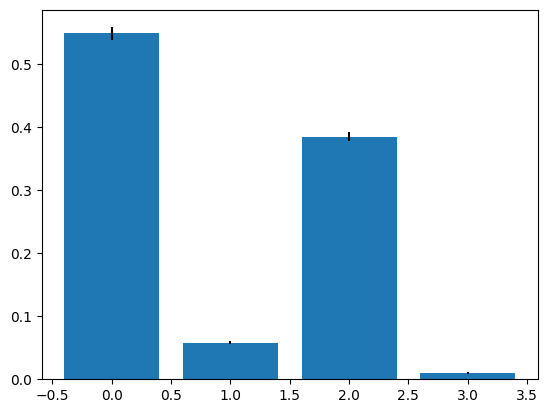

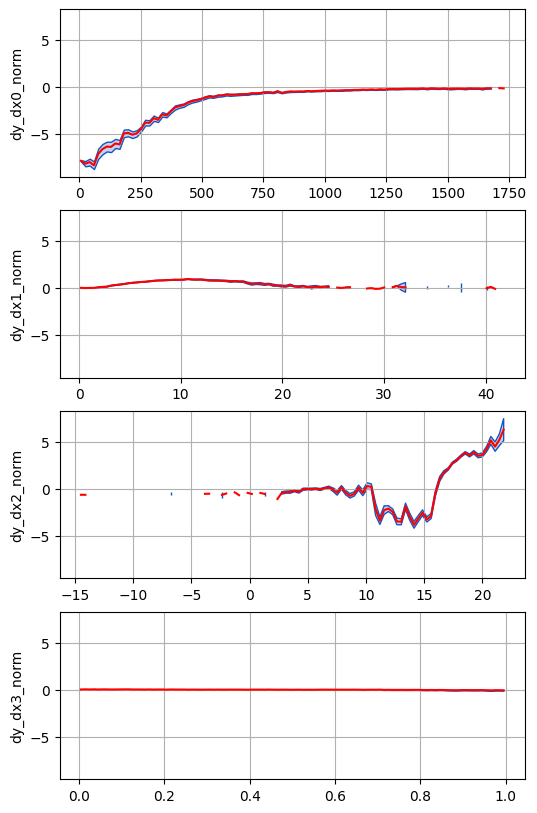

In [34]:
# print(inputs)

# importlib.reload(PlotHelpers)
# importlib.reload(MiscFuncs)
# importlib.reload(NNetFuncs)

# RI,out_dx = NNetFuncs.predict_Model(Examples[Set][f'X_train_{norm}'],
#                                     x_raw=Examples[Set][f'X_train_{norm}'],
#                                     target=Examples[Set]['Y_train'],
#                                     Norm=True)

print(metrics.r2_score(out_dx['target'],out_dx['y_bar']))
print(metrics.mean_squared_error(out_dx['target'],out_dx['y_bar'])**.5)

mod = '_norm'

fig,ax=plt.subplots()
ax.bar(RI.index,RI[f'RI{mod}'],yerr=RI[f'RI{mod}_95'])

print(RI)

npi=4

fig,axes=plt.subplots(npi,sharey=True,figsize=(6,10))

for i in range(npi):
    df = MiscFuncs.byInterval(out_dx,f'x{i}',[f'dy_dx{i}{mod}'],bins=100)
    PlotHelpers.CI_Plot(axes[i],df,f'dy_dx{i}{mod}')